# MIT dataset

In [1]:
# import some common libraries
import numpy as np
import torch
import torch.nn as nn
import os

import matplotlib.pyplot as plt
from train import train_with_config, train
from evaluator import *
from model import CompoResnet
from symnet.utils import dataset
import tqdm
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 
  
%load_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/mitstates/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


53753 activations loaded
#images = 34562


In [2]:
# train [img, attr_id, obj_id, pair_id, img_feature, img, attr_id, obj_id, pair_id, img_feature, aff_mask]
# test [img, attr_id, obj_id, pair_id, img_feature, aff_mask]

train_dataloader = dataset.get_dataloader('MITg', 'train', batchsize=64, with_image=True, shuffle=True)
test_dataloader = dataset.get_dataloader('MITg', 'test', batchsize=64, with_image=True)

53753 activations loaded
natural split train
#images = 30338
53753 activations loaded
natural split test
#images = 12995


In [3]:
train_dataloader = dataset.get_dataloader('UTg', 'train', batchsize=64, with_image=True, shuffle=True)
test_dataloader = dataset.get_dataloader('UTg', 'test', batchsize=64, with_image=True)

29126 activations loaded
natural split train
#images = 22998
29126 activations loaded
natural split test
#images = 2914


In [3]:
num_mlp_layers = 1
resnet_name = 'resnet18'
compoResnet = CompoResnet(resnet_name, num_mlp_layers).to(dev)

obj_loss_history = [[],[]]
attr_loss_history = [[],[]]
optimizer = torch.optim.AdamW(compoResnet.parameters(), lr=0.0015)
criterion = nn.CrossEntropyLoss()
curr_epoch = 0

model_dir = './models/'
load_model_name = 'model_14.pt'
model_path = None if not load_model_name else os.path.join(model_dir, load_model_name)

if model_path:
  #checkpoint = torch.load(model_path), map_location=torch.device('cpu'))
  checkpoint = torch.load(model_path)
  compoResnet.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  obj_loss_history = checkpoint['obj_loss']
  attr_loss_history = checkpoint['attr_loss']

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
num_epochs = 10
batch_size = 64
curr_epoch = 0
model_name = 'model_ut'
train(compoResnet, optimizer, criterion, num_epochs, obj_loss_history, attr_loss_history, batch_size, train_dataloader, 
      test_dataloader=test_dataloader, curr_epoch=curr_epoch, model_name=model_name, model_dir=model_dir)

In [4]:
evaluator = CompoResnetEvaluator(test_dataloader, 20)

In [8]:
obj_acc, attr_acc, report_cw, report_ow  = evaluator.eval_model(compoResnet)

print('A:{:.3f}|O:{:.3f}|CwSeen:{:.3f}|CwUnseen:{:.3f}|CwHM:{:.3f}|CwAUC:{:.5f}|OpSeen:{:.3f}|OpUnseen:{:.3f}|OpHM:{:.3f}|OpAUC:{:.5f}|'.format(
  attr_acc, obj_acc, *report_cw, *report_ow))

100%|██████████| 204/204 [00:27<00:00,  7.45it/s]


A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.203|OpUnseen:0.060|OpHM:0.062|OpAUC:0.00706|


**Hard masking**

In [ ]:
def calc_fscore(self):
  def cos_sim(x, y):
    x, y = torch.tensor(x).to(dev), torch.tensor(y).unsqueeze(0).to(dev)
    return cos(x, y)
  fscore = torch.ones_like(self.seen_mask, dtype=torch.float)
  word2vec = KeyedVectors.load_word2vec_format(self.word2vec_path, binary=True)
  cos = torch.nn.CosineSimilarity(dim=1)
  for i in tqdm.tqdm(range(self.attr_class * self.obj_class), total=self.attr_class*self.obj_class):
    attr_id = i // self.obj_class
    obj_id = i % self.obj_class
    if self.unseen_mask_ow[attr_id, obj_id]:
      attr, obj = self.attrs[attr_id], self.objs[obj_id]
      paired_attrs_with_obj = self.attrs[self.seen_mask[:, obj_id].cpu()]
      paired_objs_with_attr = self.objs[self.seen_mask[attr_id, :].cpu()]
      obj_score = max(cos_sim(word2vec[paired_objs_with_attr], word2vec[obj]))
      attr_score = max(cos_sim(word2vec[paired_attrs_with_obj], word2vec[attr]))
      fscore[attr_id, obj_id] = (obj_score + attr_score) / 2
  return fscore

def eval_model(self, net):
  """Return: Tuple of (closed_world_report, open_word_report).
  report: best_seen, best_unseen, best_harmonic, auc
  """
  obj_scores, attr_scores = [], []
  with torch.no_grad():
    net.eval()
    for i, batch in tqdm.tqdm(
        enumerate(self.test_dataloader),
        total=len(self.test_dataloader),
        position=0,
        leave=True):
      img, attr_id, obj_id = batch[:3]
      scores = net(img.to(dev))
      obj_scores.append(scores[0])
      attr_scores.append(scores[1])

  obj_scores = torch.cat(obj_scores)
  attr_scores = torch.cat(attr_scores)
  compo_scores = self.get_composcores(obj_scores, attr_scores)
  compo_scores[:, self.fscore_mask] = -1e10

  obj_acc = self.acc(obj_scores, self.obj_labels)
  attr_acc = self.acc(attr_scores, self.attr_labels)
  acc_cw = self.compo_acc(compo_scores)
  acc_ow = self.compo_acc(compo_scores, open_world=True)
  report_cw = self.analyse_acc_report(acc_cw)
  report_ow = self.analyse_acc_report(acc_ow)

  return obj_acc, attr_acc, report_cw, report_ow

self = evaluator
self.word2vec_path = './GoogleNews-vectors-negative300.bin'
fscore = calc_fscore(self)

In [ ]:
results = []
for t in tqdm.tqdm(np.linspace(0.1, 0.5, 20), total=20):
  self.fscore_mask = fscore < t
  results.append(eval_model(self, compoResnet))

In [15]:
auc = [result[-1][-1] for result in results]

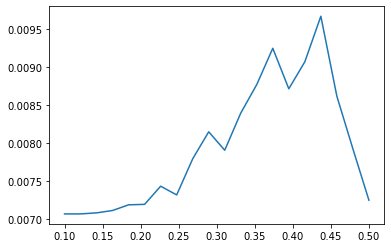

In [16]:
plt.plot(np.linspace(0.1, 0.5, 20), auc)

In [ ]:
evaluator = CompoResnetEvaluatorFscore(test_dataloader, 20, 0.27, './GoogleNews-vectors-negative300.bin')

In [18]:
obj_acc, attr_acc, report_cw, report_ow = results[np.argmax(auc)]

In [19]:
#obj_acc, attr_acc, report_cw, report_ow  = evaluator.eval_model(compoResnet)

print('A:{:.3f}|O:{:.3f}|CwSeen:{:.3f}|CwUnseen:{:.3f}|CwHM:{:.3f}|CwAUC:{:.5f}|OpSeen:{:.3f}|OpUnseen:{:.3f}|OpHM:{:.3f}|OpAUC:{:.5f}|'.format(
  attr_acc, obj_acc, *report_cw, *report_ow))

A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.143|CwHM:0.102|CwAUC:0.01897|OpSeen:0.203|OpUnseen:0.078|OpHM:0.072|OpAUC:0.00967|


**Without applying Fscore**

In [11]:
obj_acc, attr_acc, report_cw, report_ow  = evaluator.eval_model(compoResnet)

print('A:{:.3f}|O:{:.3f}|CwSeen:{:.3f}|CwUnseen:{:.3f}|CwHM:{:.3f}|CwAUC:{:.5f}|OpSeen:{:.3f}|OpUnseen:{:.3f}|OpHM:{:.3f}|OpAUC:{:.5f}|'.format(
  attr_acc, obj_acc, *report_cw, *report_ow))

100%|██████████| 204/204 [00:26<00:00,  7.57it/s]


A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.203|OpUnseen:0.060|OpHM:0.062|OpAUC:0.00706|


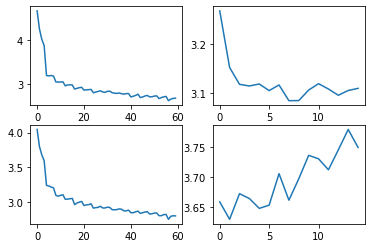

In [16]:
plt.subplot(2, 2, 1)
plt.plot(obj_loss_history[0])
plt.subplot(2, 2, 2)
plt.plot(obj_loss_history[1])
plt.subplot(2, 2, 3)
plt.plot(attr_loss_history[0])
plt.subplot(2, 2, 4)
plt.plot(attr_loss_history[1])

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "resnet": tune.choice(['resnet18', 'resnet50', 'resnet101']),
    "num_mlp_layers": tune.choice([1,2,4,6]),
}

In [ ]:
num_samples = 12
num_epochs = 6
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=num_epochs,
        grace_period=1,
        reduction_factor=2)
reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_with_config, num_epochs=num_epochs),
    resources_per_trial={"cpu": 1, "gpu": 0.32},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

resnet = frozen(torch.hub.load('pytorch/vision:v0.9.0', best_trial.config["resnet"], pretrained=True))
best_mlp = partial(HalvingMLP, num_layers=best_trial.config["num_mlp_layers"])
best_trained_model = CompoResnet(resnet, obj_class, attr_class, best_mlp).to(dev)

best_checkpoint_dir = best_trial.checkpoint.value
model_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))['model_state_dict']
best_trained_model.load_state_dict(model_state)

test_acc = calc_acc(best_trained_model, test_dataloader)
print("\nBest trial test set accuracy: {}".format(test_acc))

Matches:

[0.30456985, 0.15528112, 0.02720025] : MLP2, 30 Epochs, Adam